In [1]:
# %%
!pip install wget sox libsndfile1 ffmpeg libsox-fmt-mp3 unidecode matplotlib soundfile
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[all]



  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement libsndfile1 (from versions: none)
ERROR: No matching distribution found for libsndfile1
DEPRECATION: git+https://github.com/NVIDIA/NeMo.git@main#egg=nemo_toolkit[all] contains an egg fragment with a non-PEP 508 name pip 25.0 will enforce this behaviour change. A possible replacement is to use the req @ url syntax, and remove the egg fragment. Discussion can be found at https://github.com/pypa/pip/issues/11617
  Cloning https://github.com/NVIDIA/NeMo.git (to revision main) to /tmp/pip-install-5ra60qi1/nemo-toolkit_cc0ec4b639c04aad84387511b9dd7fbe
  Running command git clone --filter=blob:none --quiet https://github.com/NVIDIA/NeMo.git /tmp/pip-install-5ra60qi1/nemo-toolkit_cc0ec4b639c04aad84387511b9dd7fbe
  Resolved https://github.com/NVIDIA/NeMo.git to commit 75e51

In [2]:
!pip install urllib3==1.26.15 --force-reinstall


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.9/140.9 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.20
    Uninstalling urllib3-1.26.20:
      Successfully uninstalled urllib3-1.26.20
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.24.4 which is incompatible.
google-colab 1.0.0 requires google-auth==2.38.0, but you have google-auth 2.40.1 which is incompatible.
google-colab 1.0.0 requires notebook==6.5.7, but you have notebook 6.5.4 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
moviepy 1.0.3 requires deco

In [3]:
import os
import json
import copy
from tqdm.auto import tqdm
import librosa
import soundfile as sf
import numpy as np
import torch
import torch.nn as nn
from lightning.pytorch import Trainer
from omegaconf import OmegaConf, open_dict
import nemo
import nemo.collections.asr as nemo_asr
from nemo.utils import logging, exp_manager
from datasets import load_dataset, Dataset
from nemo.collections.asr.metrics.wer import word_error_rate
from nemo.collections.asr.models import EncDecCTCModel


In [4]:
DATA_DIR = '/kaggle/input/vivos-corpus-hcmus/vivos'

train_manifest = os.path.join(DATA_DIR, 'train_manifest.json')
val_manifest   = os.path.join(DATA_DIR, 'test_manifest.json')
test_manifest  = os.path.join(DATA_DIR, 'test_manifest.json')


def read_manifest(path: str):
    data = []
    with open(path, 'r', encoding='utf8') as f:
        for line in tqdm(f, desc=f"Reading {os.path.basename(path)}"):
            data.append(json.loads(line))
    return data

train_manifest_data = read_manifest(train_manifest)
val_manifest_data   = read_manifest(val_manifest)
test_manifest_data  = read_manifest(test_manifest)


Reading train_manifest.json: 0it [00:00, ?it/s]

Reading test_manifest.json: 0it [00:00, ?it/s]

Reading test_manifest.json: 0it [00:00, ?it/s]

In [5]:
from collections import defaultdict

def get_charset(manifest_data) -> list:
    freq = defaultdict(int)
    for row in tqdm(manifest_data, desc="Computing charset"):
        for ch in row['text']:
            freq[ch] += 1
    
    # Build Vietnamese character set
    basic_chars = [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
    vietnamese_chars = ['à', 'á', 'ả', 'ã', 'ạ', 'ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 
                       'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'ê', 'ề', 'ế', 'ể', 'ễ', 'ệ',
                       'ì', 'í', 'ỉ', 'ĩ', 'ị', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ',
                       'ù', 'ú', 'ủ', 'ũ', 'ụ', 'ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'đ']
    
    # Get frequent characters from actual data
    sorted_chars = sorted(freq.items(), key=lambda x: x[1], reverse=True)
    frequent_chars = [char for char, count in sorted_chars if count >= 5]
    
    # Combine all and remove duplicates
    all_chars = list(set(basic_chars + vietnamese_chars))
    
    return sorted(all_chars)

train_set = get_charset(train_manifest_data)
print(f"# tokens in train set: {len(train_set)}")
print("Sample characters:", train_set[:30])

Computing charset:   0%|          | 0/11660 [00:00<?, ?it/s]

# tokens in train set: 94
Sample characters: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'á', 'â']


In [6]:
char_model = nemo_asr.models.ASRModel.from_pretrained("stt_en_quartznet15x5")


[NeMo I 2025-05-31 15:32:10 nemo_logging:393] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_quartznet15x5/versions/1.0.0rc1/files/stt_en_quartznet15x5.nemo to /root/.cache/torch/NeMo/NeMo_2.4.0rc0/stt_en_quartznet15x5/16661021d16e679bdfd97a2a03944c49/stt_en_quartznet15x5.nemo
[NeMo I 2025-05-31 15:32:10 nemo_logging:393] Instantiating model from pre-trained checkpoint


[NeMo W 2025-05-31 15:32:12 nemo_logging:405] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath: /data2/voices/train_1k.json
    sample_rate: 16000
    labels:
    - ' '
    - a
    - b
    - c
    - d
    - e
    - f
    - g
    - h
    - i
    - j
    - k
    - l
    - m
    - 'n'
    - o
    - p
    - q
    - r
    - s
    - t
    - u
    - v
    - w
    - x
    - 'y'
    - z
    - ''''
    batch_size: 32
    trim_silence: true
    max_duration: 16.7
    shuffle: true
    is_tarred: false
    tarred_audio_filepaths: /asr_set_1.2/train/train_{0..1023}.tar
    num_workers: 20
    
[NeMo W 2025-05-31 15:32:12 nemo_logging:405] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loade

[NeMo I 2025-05-31 15:32:12 nemo_logging:393] PADDING: 16
[NeMo I 2025-05-31 15:32:13 nemo_logging:393] Model EncDecCTCModel was successfully restored from /root/.cache/torch/NeMo/NeMo_2.4.0rc0/stt_en_quartznet15x5/16661021d16e679bdfd97a2a03944c49/stt_en_quartznet15x5.nemo.


In [7]:
char_model.change_vocabulary(new_vocabulary=list(train_set))

[NeMo I 2025-05-31 15:32:13 nemo_logging:393] Changed decoder to output to [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'á', 'â', 'ã', 'è', 'é', 'ê', 'ì', 'í', 'ò', 'ó', 'ô', 'õ', 'ù', 'ú', 'ý', 'ă', 'đ', 'ĩ', 'ũ', 'ơ', 'ư', 'ạ', 'ả', 'ấ', 'ầ', 'ẩ', 'ẫ', 'ậ', 'ắ', 'ằ', 'ẳ', 'ẵ', 'ặ', 'ẹ', 'ẻ', 'ẽ', 'ế', 'ề', 'ể', 'ễ', 'ệ', 'ỉ', 'ị', 'ọ', 'ỏ', 'ố', 'ồ', 'ổ', 'ỗ', 'ộ', 'ớ', 'ờ', 'ở', 'ỡ', 'ợ', 'ụ', 'ủ', 'ứ', 'ừ', 'ử', 'ữ', 'ự', 'ỳ', 'ỵ', 'ỷ', 'ỹ'] vocabulary.


In [8]:
char_model.cfg.labels = list(train_set)

In [9]:
freeze_encoder = False #@param ["False", "True"] {type:"raw"}
freeze_encoder = bool(freeze_encoder)

import torch
import torch.nn as nn

def enable_bn_se(m):
    if type(m) == nn.BatchNorm1d:
        m.train()
        for param in m.parameters():
            param.requires_grad_(True)

    if 'SqueezeExcite' in type(m).__name__:
        m.train()
        for param in m.parameters():
            param.requires_grad_(True)

if freeze_encoder:
    char_model.encoder.freeze()
    char_model.encoder.apply(enable_bn_se)
    logging.info("Model encoder has been frozen, and batch normalization has been unfrozen")
else:
    char_model.encoder.unfreeze()
    logging.info("Model encoder has been un-frozen")

[NeMo I 2025-05-31 15:32:13 nemo_logging:393] Model encoder has been un-frozen


In [10]:
cfg = copy.deepcopy(char_model.cfg)

In [11]:
# Setup train, validation, test configs
with open_dict(cfg):    
  # Train dataset  (Concatenate train manifest cleaned and dev manifest cleaned)
  cfg.train_ds.manifest_filepath = f"{train_manifest}"
  cfg.train_ds.labels = list(train_set)
  cfg.train_ds.normalize_transcripts = False
  cfg.train_ds.batch_size = 16
  cfg.train_ds.num_workers = 8
  cfg.train_ds.pin_memory = True
  cfg.train_ds.trim_silence = True

  # Validation dataset  (Use test dataset as validation, since we train using train + dev)
  cfg.validation_ds.manifest_filepath = val_manifest
  cfg.validation_ds.labels = list(train_set)
  cfg.validation_ds.normalize_transcripts = False
  cfg.validation_ds.batch_size = 8
  cfg.validation_ds.num_workers = 4
  cfg.validation_ds.pin_memory = True
  cfg.validation_ds.trim_silence = True

In [12]:
# setup data loaders with new configs
char_model.setup_training_data(cfg.train_ds)
char_model.setup_multiple_validation_data(cfg.validation_ds)

[NeMo I 2025-05-31 15:32:14 nemo_logging:393] Dataset loaded with 11657 files totalling 14.91 hours
[NeMo I 2025-05-31 15:32:14 nemo_logging:393] 3 files were filtered totalling 0.01 hours
[NeMo I 2025-05-31 15:32:14 nemo_logging:393] Dataset loaded with 760 files totalling 0.75 hours
[NeMo I 2025-05-31 15:32:14 nemo_logging:393] 0 files were filtered totalling 0.00 hours


In [13]:
# Original optimizer + scheduler
print(OmegaConf.to_yaml(char_model.cfg.optim))

name: novograd
lr: 0.01
betas:
- 0.8
- 0.5
weight_decay: 0.001
sched:
  name: CosineAnnealing
  warmup_steps: null
  warmup_ratio: null
  min_lr: 0.0
  last_epoch: -1



In [14]:
with open_dict(char_model.cfg.optim):
  char_model.cfg.optim.lr = 0.01
  char_model.cfg.optim.betas = [0.95, 0.5]  # from paper
  char_model.cfg.optim.weight_decay = 0.001  # Original weight decay
  char_model.cfg.optim.sched.name = 'CosineAnnealing' 
  char_model.cfg.optim.sched.warmup_steps = 1000  # Remove default number of steps of warmup
  char_model.cfg.optim.sched.min_lr = 1e-5

In [15]:
# with open_dict(char_model.cfg.spec_augment):
#   char_model.cfg.spec_augment.freq_masks = 1
#   char_model.cfg.spec_augment.freq_width = 27
#   char_model.cfg.spec_augment.time_masks = 1
#   char_model.cfg.spec_augment.time_width = 50

# char_model.spec_augmentation = char_model.from_config_dict(char_model.cfg.spec_augment)

In [16]:
# Verify labels
print("=== VERIFICATION ===")
print(f"Vietnamese charset: {train_set[:10]}...")
print(f"Model labels: {char_model.cfg.labels[:10]}...")
print(f"Labels match: {char_model.cfg.labels == train_set}")
print(f"Model vocab size: {len(char_model.cfg.labels)}")

=== VERIFICATION ===
Vietnamese charset: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']...
Model labels: [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']...
Labels match: True
Model vocab size: 94


In [17]:
print(f"Total parameters: {sum(p.numel() for p in char_model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in char_model.parameters() if p.requires_grad):,}")

Total parameters: 18,992,031
Trainable parameters: 18,992,031


In [18]:
from lightning.pytorch.callbacks import Callback
import torch

In [19]:
class HistoryCallback(Callback):
    def __init__(self, validation_data=None):
        self.train_losses = []
        self.val_wers = []
        self.learning_rates = []
        self.validation_data = validation_data
    
    def on_train_epoch_end(self, trainer, pl_module):
        loss = trainer.callback_metrics.get("train_loss")
        lr = trainer.optimizers[0].param_groups[0]["lr"]
        if loss is not None:
            # Convert tensor to float if necessary
            if isinstance(loss, torch.Tensor):
                loss = loss.item()
            self.train_losses.append(loss)
            print(f"Epoch {trainer.current_epoch} Training Loss: {loss:.4f}")
        if lr is not None:
            self.learning_rates.append(lr)
    
    def on_validation_epoch_end(self, trainer, pl_module):
        wer = trainer.callback_metrics.get("val_wer")
        if wer is not None:
            # Convert tensor to float if necessary
            if isinstance(wer, torch.Tensor):
                wer = wer.item()
            self.val_wers.append(wer)
            print(f"Epoch {trainer.current_epoch} Validation WER: {wer * 100:.2f}%")
            
            # Print sample prediction
            if self.validation_data and len(self.validation_data) > 0:
                sample = self.validation_data[0]  # Get first sample
                audio_path = sample['audio_filepath']
                ground_truth = sample['text']
                
                # Get prediction
                with torch.no_grad():
                    prediction = pl_module.transcribe([audio_path])[0]
                
                print("="*50)
                print("SAMPLE PREDICTION:")
                print(f"Audio: {audio_path}")
                print(f"Ground Truth: '{ground_truth}'")
                print(f"Prediction:   '{prediction}'")
                print("="*50)

history_cb = HistoryCallback(validation_data=val_manifest_data)

# Trainer optimized for fine-tuning pretrained QuartzNet
trainer = Trainer(
    devices=1,
    accelerator='cuda' if torch.cuda.is_available() else 'cpu',
    max_epochs=50,  # Fewer epochs for fine-tuning
    callbacks=[history_cb],
    logger=False,             
    enable_checkpointing=False,
    precision='16-mixed',
    gradient_clip_val=1.0,
    accumulate_grad_batches=4,  # Effective batch size = 16 * 4 = 64
    val_check_interval=1.0,
    log_every_n_steps=50,
    enable_progress_bar=True,
    max_time="12:00:00:00",  # Max 6 hours for fine-tuning
)

char_model.set_trainer(trainer)

exp_cfg = exp_manager.ExpManagerConfig(
    exp_dir='experiments/quartznet_15x5_vietnamese',
    name='QuartzNet15x5-Vietnamese-FineTuned',
    create_checkpoint_callback=True,
    checkpoint_callback_params=exp_manager.CallbackParams(
        monitor='val_wer', 
        mode='min', 
        always_save_nemo=True, 
        save_best_model=True,
        save_top_k=5,
        every_n_epochs=1,
        save_on_train_epoch_end=False,
    ),
    create_tensorboard_logger=True,
    create_wandb_logger=False,
    resume_if_exists=False,  # Resume if interrupted
)

exp_cfg = OmegaConf.structured(exp_cfg)
logdir = exp_manager.exp_manager(trainer, exp_cfg)

# %% [markdown]
# # Training
# %%
print("=" * 60)
print("STARTING QUARTZNET 15X5 FINE-TUNING")
print("=" * 60)
print(f"Architecture: QuartzNet 15x5 (Pretrained)")
print(f"Total Parameters: {sum(p.numel() for p in char_model.parameters()):,}")
print(f"Training samples: {len(train_manifest_data):,}")
print(f"Validation samples: {len(val_manifest_data):,}")
print(f"Character vocabulary size: {len(train_set)}")
print(f"Max epochs: {trainer.max_epochs}")
print("=" * 60)

try:
    trainer.fit(char_model)
    print("Training completed successfully!")
    
    # Save final model
    char_model.save_to('quartznet_vietnamese_final.nemo')
    print("Model saved as 'quartznet_vietnamese_final.nemo'")
    
except KeyboardInterrupt:
    print("Training interrupted by user")
    # Save current state
    char_model.save_to('quartznet_vietnamese_interrupted.nemo')
    print("Model saved as 'quartznet_vietnamese_interrupted.nemo'")
    
except Exception as e:
    print(f"Training failed with error: {e}")
    import traceback
    traceback.print_exc()

[NeMo I 2025-05-31 15:32:14 nemo_logging:393] ExpManager schema
[NeMo I 2025-05-31 15:32:14 nemo_logging:393] {'explicit_log_dir': None, 'exp_dir': None, 'name': None, 'version': None, 'use_datetime_version': True, 'resume_if_exists': False, 'resume_past_end': False, 'resume_ignore_no_checkpoint': False, 'resume_from_checkpoint': None, 'create_tensorboard_logger': True, 'summary_writer_kwargs': None, 'create_wandb_logger': False, 'wandb_logger_kwargs': None, 'create_mlflow_logger': False, 'mlflow_logger_kwargs': {'experiment_name': None, 'run_name': None, 'tracking_uri': None, 'tags': None, 'save_dir': './mlruns', 'prefix': '', 'artifact_location': None, 'run_id': None, 'log_model': False}, 'create_dllogger_logger': False, 'dllogger_logger_kwargs': {'verbose': False, 'stdout': False, 'json_file': './dllogger.json'}, 'create_clearml_logger': False, 'clearml_logger_kwargs': {'project': None, 'task': None, 'connect_pytorch': False, 'model_name': None, 'tags': None, 'log_model': False, 'lo

2025-05-31 15:32:16.727535: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748705536.952605      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748705537.019495      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2025-05-31 15:32:28 nemo_logging:393] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.95, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2025-05-31 15:32:28 nemo_logging:393] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7c963c6b7dd0>" 
    will be used during training (effective maximum steps = 9150) - 
    Parameters : 
    (warmup_steps: 1000
    warmup_ratio: null
    min_lr: 1.0e-05
    last_epoch: -1
    max_steps: 9150
    )


INFO: 
  | Name              | Type                              | Params | Mode 
--------------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0      | train
1 | encoder           | ConvASREncoder                    | 18.9 M | train
2 | spec_augmentation | SpectrogramAugmentation           | 0      | train
3 | wer               | WER                               | 0      | train
4 | decoder           | ConvASRDecoder                    | 97.4 K | train
5 | loss              | CTCLoss                           | 0      | train
--------------------------------------------------------------------------------
19.0 M    Trainable params
0         Non-trainable params
19.0 M    Total params
75.968    Total estimated model params size (MB)
607       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-31 15:32:49 nemo_logging:393] Preemption requires torch distributed to be initialized, disabling preemption


Validation: |          | 0/? [00:00<?, ?it/s]

[NeMo I 2025-05-31 15:39:56 nemo_logging:393] Checkpoint save for step 183 started at 1748705996.2142322.
[NeMo I 2025-05-31 15:39:57 nemo_logging:393] Checkpoint save for step 183 started at 1748705997.0411992.
[NeMo I 2025-05-31 15:39:57 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
Epoch 0 Training Loss: 117.4383


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1 Validation WER: 98.19%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 18.53it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-10.8474), y_sequence=tensor([20, 94, 94, 94, 38,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, 44, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
         0,  0, 20, 94, 94,  8,  8, 94, 41, 94,  0,  0, 44, 94, 94, 94, 94, 94,
        94, 37, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='tô đ thú đó', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngram_l

[NeMo I 2025-05-31 15:47:07 nemo_logging:393] Checkpoint save for step 366 started at 1748706427.8231587.
[NeMo I 2025-05-31 15:47:08 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 15:47:08 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 15:47:08 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2 Validation WER: 86.32%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.03it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-11.1772), y_sequence=tensor([ 3, 94, 94, 94, 27, 94,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  2, 94, 94, 94, 94, 94, 94, 94, 94, 94,  1,  9,  0,  0, 20,
        94, 94, 94,  8, 94, 94, 75,  9,  0,  0, 22, 94, 94, 94, 94, 94, 71, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='cà bai thổi vọ', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngra

[NeMo I 2025-05-31 15:54:15 nemo_logging:393] Checkpoint save for step 549 started at 1748706855.4398432.
Epoch 2 Training Loss: 55.6053


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3 Validation WER: 87.52%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.69it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-7.3714), y_sequence=tensor([20, 94, 94, 94, 28, 94,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 28, 94, 94,
         0, 20, 94, 94,  8, 94, 94, 84, 94,  0,  0, 20, 94, 94, 94, 18, 94, 71,
        14,  7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='tá ná thủ trọng', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngra

[NeMo I 2025-05-31 16:01:26 nemo_logging:393] Checkpoint save for step 732 started at 1748707286.6080174.
[NeMo I 2025-05-31 16:01:26 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 16:01:27 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 16:01:27 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4 Validation WER: 81.87%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 28.45it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-10.2707), y_sequence=tensor([20,  8, 94, 94, 64, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0, 14, 94, 94, 94, 94, 94, 94,  8,  8, 94, 65, 21,  0,  0,
        20, 94, 94, 94,  8, 94, 94, 84, 94, 94,  0, 44, 94, 94, 94, 94, 71, 14,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='thến nhều thủ đọn', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, n

[NeMo I 2025-05-31 16:08:36 nemo_logging:393] Checkpoint save for step 915 started at 1748707716.7544878.
[NeMo I 2025-05-31 16:08:37 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 16:08:37 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 16:08:37 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 5 Validation WER: 77.03%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 28.08it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-8.4665), y_sequence=tensor([ 3,  8, 94, 94, 84, 94,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 44, 94, 94, 94, 94, 94, 94,  1, 94, 94,  0,  3, 94,
        94, 94, 94, 94,  8, 94, 94, 84, 94, 94,  0, 44, 94, 94, 94, 94, 94, 77,
        14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='chủ đa chủ độn', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngram

[NeMo I 2025-05-31 16:15:46 nemo_logging:393] Checkpoint save for step 1098 started at 1748708146.8036208.
[NeMo I 2025-05-31 16:15:47 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 16:15:48 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 16:15:48 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 6 Validation WER: 69.96%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 25.02it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-9.4075), y_sequence=tensor([ 3,  8, 94, 94, 15, 94,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 14, 94, 94, 94, 94, 94, 94, 94,  7, 94, 94, 27, 94,  0,  0, 20,
        94, 94, 94,  8, 94, 94, 74, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 49,
        14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='cho ngà thồ đạn', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngra

[NeMo I 2025-05-31 16:22:58 nemo_logging:393] Checkpoint save for step 1281 started at 1748708578.0045617.
[NeMo I 2025-05-31 16:22:58 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 16:22:58 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 16:22:58 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7 Validation WER: 68.03%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 25.97it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-9.2915), y_sequence=tensor([19, 94, 94, 94,  1, 94,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14, 94,  0,
        20, 94, 94,  8,  8, 94, 40, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 77,
        14,  7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='sa nên thù động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngra

[NeMo I 2025-05-31 16:30:08 nemo_logging:393] Checkpoint save for step 1464 started at 1748709008.0414584.
[NeMo I 2025-05-31 16:30:09 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 16:30:09 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 16:30:09 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8 Validation WER: 64.25%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 26.92it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-9.0937), y_sequence=tensor([ 4,  8, 94, 94, 50, 94,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 78, 14, 94,  0, 20,
        94, 94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 94, 77,
        14,  7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='dhả nớn thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 16:37:19 nemo_logging:393] Checkpoint save for step 1647 started at 1748709439.120549.
[NeMo I 2025-05-31 16:37:19 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 16:37:19 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 16:37:19 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9 Validation WER: 59.92%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 28.76it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-7.2698), y_sequence=tensor([20, 94, 94, 94, 28, 94,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94,  5, 94, 94,  0, 20,
        94, 94,  8, 94, 94, 75, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 94, 77,
        20, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='tá ne thổ đột', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngram_

[NeMo I 2025-05-31 16:44:27 nemo_logging:393] Checkpoint save for step 1830 started at 1748709867.8128293.
Epoch 9 Training Loss: 54.2434


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10 Validation WER: 60.88%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 25.87it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-3.7975), y_sequence=tensor([20, 94, 94, 94, 66, 94,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0,
        20, 94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 74,
        14,  7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='tể ên thủ đồng', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngram

[NeMo I 2025-05-31 16:51:38 nemo_logging:393] Checkpoint save for step 2013 started at 1748710298.9623446.
[NeMo I 2025-05-31 16:51:39 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 16:51:39 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 16:51:39 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 11 Validation WER: 54.84%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 28.05it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-4.8921), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7,  8, 94, 33, 14,  0,  0, 20, 20,
        94, 94,  8, 94, 94, 40, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở nghên thù động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, n

[NeMo I 2025-05-31 16:58:50 nemo_logging:393] Checkpoint save for step 2196 started at 1748710730.0699134.
[NeMo I 2025-05-31 16:58:50 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 16:58:50 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 16:58:50 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 12 Validation WER: 50.57%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.24it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-4.2949), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 94, 18, 94, 94,
        50, 94, 94,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14, 94,  0, 20,
        94, 94,  8, 94, 94, 40, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 94, 77,
        14,  7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trả nên thù động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 17:06:03 nemo_logging:393] Checkpoint save for step 2379 started at 1748711163.830368.
[NeMo I 2025-05-31 17:06:04 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 17:06:04 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 17:06:04 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 13 Validation WER: 49.05%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.66it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-5.6861), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94,  3, 94, 94, 94, 94, 94, 94, 94, 94,
        50, 94,  0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94,  1, 14,  0,  0, 20,
        94, 94, 94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 77,
        14,  7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='cả nan thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngra

[NeMo I 2025-05-31 17:13:10 nemo_logging:393] Checkpoint save for step 2562 started at 1748711590.8587701.
[NeMo I 2025-05-31 17:13:11 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 17:13:11 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 17:13:11 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 14 Validation WER: 48.34%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.15it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-5.8589), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94,  3, 94, 94, 94, 94,  8, 94, 94,
        50, 94,  0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0, 20,
        94, 94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 71, 14,
         7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='chả nên thủ đọng', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 17:20:22 nemo_logging:393] Checkpoint save for step 2745 started at 1748712022.5246296.
[NeMo I 2025-05-31 17:20:22 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 17:20:23 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 17:20:23 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 15 Validation WER: 47.84%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 28.05it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-4.4727), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 94, 18, 94, 94,
        50, 94,  0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0, 20,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 36, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trả nên thủ đòng', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 17:27:30 nemo_logging:393] Checkpoint save for step 2928 started at 1748712450.629459.
[NeMo I 2025-05-31 17:27:30 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 17:27:31 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 17:27:31 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 16 Validation WER: 46.10%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 24.82it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-2.9605), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 94, 94, 18, 94, 94,
        62, 94,  0,  0, 14, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20,
        94, 94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,
         7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trẻ ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 17:34:38 nemo_logging:393] Checkpoint save for step 3111 started at 1748712878.9346788.
[NeMo I 2025-05-31 17:34:39 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 17:34:39 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 17:34:39 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 17 Validation WER: 44.31%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.75it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-5.5153), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94,  3, 94, 94, 94, 94, 94,  8, 94, 94, 37, 94,
         0,  0, 14, 94, 94, 94, 94, 94,  7,  7, 94, 33, 14, 94,  0, 20, 94, 94,
        94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='chó ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 17:41:49 nemo_logging:393] Checkpoint save for step 3294 started at 1748713309.3852499.
Epoch 17 Training Loss: 55.4011


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 18 Validation WER: 46.68%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.54it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-7.5209), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 94, 18, 94, 94, 62, 94,  0,  0,
        14, 94, 94, 94, 94, 94, 94,  7,  8, 94,  5, 94,  0,  0, 20, 94, 94,  8,
         8, 94, 40, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 94, 71, 14,  7, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trẻ nghe thù đọng', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 17:48:58 nemo_logging:393] Checkpoint save for step 3477 started at 1748713738.1732423.
Epoch 18 Training Loss: 48.7002


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 19 Validation WER: 45.36%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.61it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-4.2555), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94,  3, 94, 94, 94, 94,  8, 94, 94, 80, 94,  0,
         0, 14, 94, 94, 94, 94, 94,  7,  8, 94, 33, 94,  0,  0, 20, 94, 94, 94,
         8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='chở nghê thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 17:56:03 nemo_logging:393] Checkpoint save for step 3660 started at 1748714163.2921712.
[NeMo I 2025-05-31 17:56:03 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 17:56:03 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 17:56:03 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 20 Validation WER: 40.97%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 26.07it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-2.3924), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 94, 18, 94, 94, 50,
        94,  0,  0, 14, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14, 94,  0, 20, 94,
        94, 94,  8,  8, 94, 94, 83, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,
         7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trả ngên thụ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 18:03:14 nemo_logging:393] Checkpoint save for step 3843 started at 1748714594.6852765.
Epoch 20 Training Loss: 31.6606


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 21 Validation WER: 41.18%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 26.14it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-4.8104), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 20, 20, 94, 94, 18, 94, 94, 80, 94,  0,
         0, 14, 94, 94, 94, 94, 94, 94,  7,  8, 94, 33, 14,  0,  0, 20, 94, 94,
        94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 74, 14,  7, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở nghên thủ đồng', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, n

[NeMo I 2025-05-31 18:10:24 nemo_logging:393] Checkpoint save for step 4026 started at 1748715024.8707664.
[NeMo I 2025-05-31 18:10:25 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 18:10:25 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 18:10:25 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 22 Validation WER: 40.87%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.00it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-4.5145), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 50, 94, 94,
         0, 14, 94, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 77, 14,  7, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trả ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 18:17:34 nemo_logging:393] Checkpoint save for step 4209 started at 1748715454.1467392.
[NeMo I 2025-05-31 18:17:34 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 18:17:34 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 18:17:34 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 23 Validation WER: 39.85%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 26.27it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-3.3170), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 18:24:46 nemo_logging:393] Checkpoint save for step 4392 started at 1748715886.1559973.
[NeMo I 2025-05-31 18:24:46 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 18:24:46 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 18:24:46 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 24 Validation WER: 39.06%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 26.24it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-2.8994), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 18, 94, 94, 80, 94,  0,
         0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0, 20, 94, 94,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 77, 14, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở nên thủ độn', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngra

[NeMo I 2025-05-31 18:31:55 nemo_logging:393] Checkpoint save for step 4575 started at 1748716315.159189.
[NeMo I 2025-05-31 18:31:55 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 18:31:55 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 18:31:55 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 25 Validation WER: 38.60%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.29it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-5.2751), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 94, 18, 94, 94, 79, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7,  8, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8, 94, 94, 40,  1,  0,  0, 44, 94, 94, 94, 94, 94, 74, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trờ nghên thùa đồng', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, 

[NeMo I 2025-05-31 18:39:09 nemo_logging:393] Checkpoint save for step 4758 started at 1748716749.6088407.
[NeMo I 2025-05-31 18:39:09 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 18:39:10 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 18:39:10 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 26 Validation WER: 37.78%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 28.88it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-3.8843), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 94, 18, 94, 94, 50,
        94,  0,  0, 14, 94, 94, 94, 94, 94,  7,  7, 94, 94,  5, 94,  0,  0, 20,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 77, 14,
         7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trả nge thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 18:46:17 nemo_logging:393] Checkpoint save for step 4941 started at 1748717177.1233332.
Epoch 26 Training Loss: 24.1272


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 27 Validation WER: 39.64%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 26.57it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-3.7130), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 62, 94,  0,
         0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 33, 94,  0,  0, 20, 94, 94,
        94,  8,  8, 94, 40, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trẻ nê thù động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngra

[NeMo I 2025-05-31 18:53:26 nemo_logging:393] Checkpoint save for step 5124 started at 1748717606.9207907.
[NeMo I 2025-05-31 18:53:27 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 18:53:27 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 18:53:27 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 28 Validation WER: 35.19%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.83it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-4.4558), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 18, 94, 94, 50, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 33, 33, 14,  0,  0, 20,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 77, 14,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trả nên thủ độn', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngra

[NeMo I 2025-05-31 19:00:37 nemo_logging:393] Checkpoint save for step 5307 started at 1748718037.8893735.
Epoch 28 Training Loss: 21.9323


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 29 Validation WER: 35.19%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 26.51it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-2.7445), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 94, 94, 82, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='tợ nên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngra

[NeMo I 2025-05-31 19:07:47 nemo_logging:393] Checkpoint save for step 5490 started at 1748718467.3172948.
Epoch 29 Training Loss: 17.8976


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 30 Validation WER: 36.34%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.55it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-4.9618), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94,  3, 94, 94,  8, 94, 94, 94, 80,
        94,  0,  0, 14, 94, 94, 94, 94, 94,  7,  7, 94,  1, 14,  0,  0, 20, 94,
        94, 94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='chở ngan thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 19:14:56 nemo_logging:393] Checkpoint save for step 5673 started at 1748718896.0784082.
Epoch 30 Training Loss: 14.6467


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 31 Validation WER: 35.37%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.68it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-2.6152), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 18, 94, 94, 80, 94,  0,
         0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0, 20, 94, 94,
        94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở nên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 19:22:07 nemo_logging:393] Checkpoint save for step 5856 started at 1748719327.710544.
[NeMo I 2025-05-31 19:22:08 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 19:22:09 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 19:22:09 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 32 Validation WER: 34.78%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.36it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-3.5296), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 18, 94, 94, 62, 94,  0,
         0, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0, 20, 94, 94,
        94,  8, 94, 94, 84,  9,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trẻ ên thủi động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 19:29:15 nemo_logging:393] Checkpoint save for step 6039 started at 1748719755.5761964.
[NeMo I 2025-05-31 19:29:15 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 19:29:16 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 19:29:16 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 33 Validation WER: 33.63%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.40it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-3.2112), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94,  1, 14,  0,  0, 20, 94, 94,
        94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở nan thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 19:36:22 nemo_logging:393] Checkpoint save for step 6222 started at 1748720182.177092.
[NeMo I 2025-05-31 19:36:22 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 19:36:22 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 19:36:22 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 34 Validation WER: 32.67%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 23.98it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-3.1255), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 94, 18, 94, 94, 62, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0, 20, 94, 94,
        94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trẻ nên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 19:43:33 nemo_logging:393] Checkpoint save for step 6405 started at 1748720613.9830172.
Epoch 34 Training Loss: 8.9675


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 35 Validation WER: 33.53%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 26.95it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-1.6844), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80,
        94,  0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 74, 14,
         7, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở nên thủ đồng', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 19:50:42 nemo_logging:393] Checkpoint save for step 6588 started at 1748721042.9570172.
[NeMo I 2025-05-31 19:50:43 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 19:50:43 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 19:50:43 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 36 Validation WER: 32.21%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 28.69it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-4.3668), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 18, 94, 94, 62, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trẻ ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 19:57:56 nemo_logging:393] Checkpoint save for step 6771 started at 1748721476.4131248.
Epoch 36 Training Loss: 14.2115


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 37 Validation WER: 32.38%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 25.75it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-1.2826), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở nên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 20:05:07 nemo_logging:393] Checkpoint save for step 6954 started at 1748721907.7001226.
[NeMo I 2025-05-31 20:05:08 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 20:05:08 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 20:05:08 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 38 Validation WER: 31.55%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.79it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-2.6324), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 20:12:17 nemo_logging:393] Checkpoint save for step 7137 started at 1748722337.869674.
[NeMo I 2025-05-31 20:12:18 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 20:12:18 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 20:12:18 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 39 Validation WER: 31.26%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 25.89it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-2.0870), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94, 94, 94, 94, 33, 14,  0,  0, 20, 94,
        94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở nên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ngr

[NeMo I 2025-05-31 20:19:24 nemo_logging:393] Checkpoint save for step 7320 started at 1748722764.7521498.
[NeMo I 2025-05-31 20:19:25 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 20:19:25 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 20:19:25 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 40 Validation WER: 30.74%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 28.61it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-2.2388), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 20:26:36 nemo_logging:393] Checkpoint save for step 7503 started at 1748723196.4202003.
Epoch 40 Training Loss: 16.6485


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 41 Validation WER: 31.11%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.73it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-1.4237), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 20:33:47 nemo_logging:393] Checkpoint save for step 7686 started at 1748723627.3461394.
Epoch 41 Training Loss: 10.1013


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 42 Validation WER: 31.21%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.58it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-1.3604), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 20:40:56 nemo_logging:393] Checkpoint save for step 7869 started at 1748724056.3025305.
[NeMo I 2025-05-31 20:40:56 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 20:40:56 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 20:40:56 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 43 Validation WER: 30.70%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 25.68it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-2.4599), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 50, 94,
         0,  0, 14, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94, 94,
        94,  8,  8, 94, 84, 94,  0,  0, 44, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trả ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 20:48:05 nemo_logging:393] Checkpoint save for step 8052 started at 1748724485.3686407.
[NeMo I 2025-05-31 20:48:05 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 20:48:05 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 20:48:05 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 44 Validation WER: 30.69%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 29.42it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-2.1313), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94, 94,
        94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 20:55:14 nemo_logging:393] Checkpoint save for step 8235 started at 1748724914.9919217.
[NeMo I 2025-05-31 20:55:15 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 20:55:15 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 20:55:15 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Ep

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 45 Validation WER: 30.13%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.57it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-1.4997), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 21:02:26 nemo_logging:393] Checkpoint save for step 8418 started at 1748725346.8807833.
Epoch 45 Training Loss: 3.8296


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 46 Validation WER: 30.32%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.18it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-1.0218), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8, 94, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 21:09:36 nemo_logging:393] Checkpoint save for step 8601 started at 1748725776.217057.
Epoch 46 Training Loss: 3.2819


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 47 Validation WER: 30.37%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 28.29it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-1.1122), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 21:16:48 nemo_logging:393] Checkpoint save for step 8784 started at 1748726208.676183.
[NeMo I 2025-05-31 21:16:48 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 21:16:49 nemo_logging:393] New best .nemo model saved to: /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo
[NeMo I 2025-05-31 21:16:49 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 48 Validation WER: 30.06%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 29.07it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-1.5747), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

[NeMo I 2025-05-31 21:23:57 nemo_logging:393] Checkpoint save for step 8967 started at 1748726637.1908169.
Epoch 48 Training Loss: 3.6459


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 49 Validation WER: 30.21%




Transcribing: 100%|██████████| 1/1 [00:00<00:00, 27.35it/s]

SAMPLE PREDICTION:
Audio: /kaggle/input/vivos-corpus-hcmus/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R106.wav
Ground Truth: 'trở nên thụ động'
Prediction:   'Hypothesis(score=tensor(-1.7466), y_sequence=tensor([94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 20, 94, 94, 18, 94, 94, 80, 94,
         0,  0, 14, 94, 94, 94, 94, 94, 94,  7, 94, 94, 33, 14,  0,  0, 20, 94,
        94, 94,  8,  8, 94, 84, 94,  0,  0, 44, 94, 94, 94, 94, 94, 77, 14,  7,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94, 94,
        94, 94, 94, 94, 94, 94]), text='trở ngên thủ động', dec_out=None, dec_state=None, timestamp=[], alignments=None, frame_confidence=None, token_confidence=None, word_confidence=None, length=0, y=None, lm_state=None, lm_scores=None, ng

Epoch 49 Training Loss: 14.5897
[NeMo I 2025-05-31 21:31:08 nemo_logging:393] Checkpoint save for step 9150 started at 1748727068.066615.
[NeMo I 2025-05-31 21:31:10 nemo_logging:393] /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned.nemo already exists, moving existing checkpoint to /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
[NeMo I 2025-05-31 21:31:10 nemo_logging:393] Removing old .nemo backup /kaggle/working/experiments/quartznet_15x5_vietnamese/QuartzNet15x5-Vietnamese-FineTuned/2025-05-31_15-32-14/checkpoints/QuartzNet15x5-Vietnamese-FineTuned-v1.nemo
Training completed successfully!
Model saved as 'quartznet_vietnamese_final.nemo'


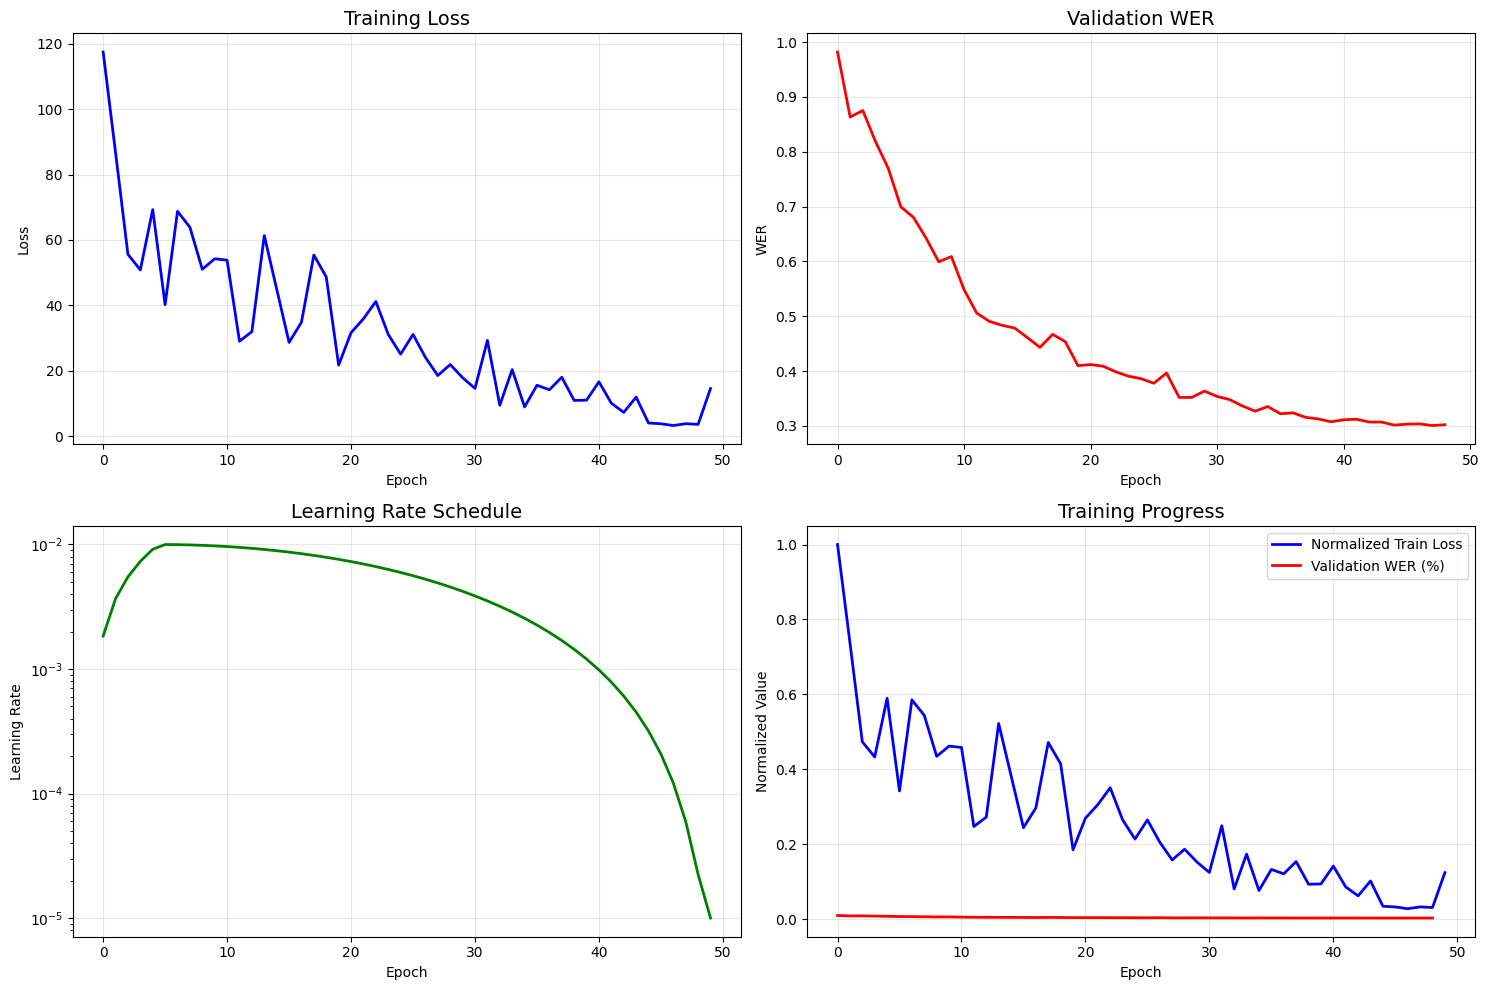


Best Validation WER: 0.30% at epoch 48
Evaluating QuartzNet 15x5 on test set...
Transcribing 760 test samples...


Transcribing: 100%|██████████| 190/190 [02:48<00:00,  1.13it/s]



FINAL TEST RESULTS
Test WER: 30.04%
Test samples: 760
Model: QuartzNet 15x5 (trained from scratch)

SAMPLE PREDICTIONS

--- Sample 1 (Index 0) ---
Audio: VIVOSDEV02_R106.wav
Duration: 2.62s
Ground Truth: 'trở nên thụ động'
Prediction:   'trở ngên thủ động'
Exact Match: ✗

--- Sample 2 (Index 190) ---
Audio: VIVOSDEV05_226.wav
Duration: 2.06s
Ground Truth: 'một cú ngoặt không chính xác'
Prediction:   'một cố hgoặch không chính sác'
Exact Match: ✗

--- Sample 3 (Index 380) ---
Audio: VIVOSDEV10_156.wav
Duration: 5.50s
Ground Truth: 'chính phủ đồng thời cũng lập thêm cục xúc tiến tiêu thụ dầu cọ'
Prediction:   'chính phủ bồng hài cũng lập hêm cọc sút kiến kêu hậu dầu cỏ'
Exact Match: ✗

--- Sample 4 (Index 570) ---
Audio: VIVOSDEV15_062.wav
Duration: 4.03s
Ground Truth: 'nghĩa là nếu bạn đang làm việc dưới quyền một giám sát viên'
Prediction:   'nghĩ là nếu bạn đang làm việc sữ quèn bở xảm xang piên'
Exact Match: ✗

--- Sample 5 (Index 759) ---
Audio: VIVOSDEV19_279.wav
Duration: 3.62s
G

In [20]:
# %% [markdown]
# # Visualize training history

# %%
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Training Loss
if history_cb.train_losses:
    axes[0, 0].plot(history_cb.train_losses, 'b-', linewidth=2)
    axes[0, 0].set_title('Training Loss', fontsize=14)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)

# Validation WER
if history_cb.val_wers:
    axes[0, 1].plot(history_cb.val_wers, 'r-', linewidth=2)
    axes[0, 1].set_title('Validation WER', fontsize=14)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('WER')
    axes[0, 1].grid(True, alpha=0.3)

# Learning Rate Schedule
if history_cb.learning_rates:
    axes[1, 0].plot(history_cb.learning_rates, 'g-', linewidth=2)
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

# Training Progress Summary
if history_cb.train_losses and history_cb.val_wers:
    # Normalize values for comparison
    norm_loss = np.array(history_cb.train_losses) / max(history_cb.train_losses)
    norm_wer = np.array(history_cb.val_wers) / 100  # WER as percentage
    
    axes[1, 1].plot(range(len(norm_loss)), norm_loss, 'b-', label='Normalized Train Loss', linewidth=2)
    axes[1, 1].plot(range(len(norm_wer)), norm_wer, 'r-', label='Validation WER (%)', linewidth=2)
    axes[1, 1].set_title('Training Progress', fontsize=14)
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Normalized Value')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print training summary
if history_cb.val_wers:
    best_wer = min(history_cb.val_wers)
    best_epoch = history_cb.val_wers.index(best_wer) + 1
    print(f"\nBest Validation WER: {best_wer:.2f}% at epoch {best_epoch}")

# %% [markdown]
# # Evaluate model

# %%
print("Evaluating QuartzNet 15x5 on test set...")

# Evaluate on full test set
test_audio_paths = [d['audio_filepath'] for d in test_manifest_data]
references = [d['text'] for d in test_manifest_data]

print(f"Transcribing {len(test_audio_paths)} test samples...")

# Transcribe in batches
predictions = char_model.transcribe(audio=test_audio_paths, batch_size=4)

# Calculate WER
test_wer = word_error_rate(hypotheses=[pred.text for pred in predictions], references=references)
print(f"\n{'='*50}")
print(f"FINAL TEST RESULTS")
print(f"{'='*50}")
print(f"Test WER: {test_wer * 100:.2f}%")
print(f"Test samples: {len(test_audio_paths)}")
print(f"Model: QuartzNet 15x5 (trained from scratch)")

# %% [markdown]
# # Test examples and analysis

# %%
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

# Show diverse examples
sample_indices = [0, len(test_audio_paths)//4, len(test_audio_paths)//2, 
                 3*len(test_audio_paths)//4, len(test_audio_paths)-1]

correct_predictions = 0
for i, idx in enumerate(sample_indices[:5]):
    if idx >= len(test_audio_paths):
        continue
        
    print(f"\n--- Sample {i+1} (Index {idx}) ---")
    print(f"Audio: {os.path.basename(test_audio_paths[idx])}")
    print(f"Duration: {test_manifest_data[idx]['duration']:.2f}s")
    print(f"Ground Truth: '{references[idx]}'")
    print(f"Prediction:   '{predictions[idx].text}'")
    
    # Check accuracy
    gt_clean = references[idx].strip().lower()
    pred_clean = predictions[idx].text.strip().lower()
    is_correct = gt_clean == pred_clean
    if is_correct:
        correct_predictions += 1
    
    print(f"Exact Match: {'✓' if is_correct else '✗'}")

print(f"\nExact matches in sample: {correct_predictions}/5")

# %% [markdown]
# # Save Model

# %%
# Save the trained model
model_save_path = os.path.join('/kaggle/working/', 'quartznet15x5_vietnamese_from_scratch.nemo')
try:
    char_model.save_to(model_save_path)
    print(f"\nModel saved successfully to: {model_save_path}")
except Exception as e:
    print(f"Error saving model: {e}")

# Save training history
history_path = os.path.join('/kaggle/working/', 'training_history.json')
history_data = {
    'train_losses': history_cb.train_losses,
    'val_wers': history_cb.val_wers,
    'learning_rates': history_cb.learning_rates,
    'test_wer': test_wer * 100,
    'total_epochs': len(history_cb.train_losses),
    'best_val_wer': min(history_cb.val_wers) if history_cb.val_wers else None
}

with open(history_path, 'w') as f:
    json.dump(history_data, f, indent=2)

print(f"Training history saved to: {history_path}")

print("\n" + "="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Model: QuartzNet 15x5 (from scratch)")
print(f"Language: Vietnamese")
print(f"Total parameters: {sum(p.numel() for p in char_model.parameters()):,}")
print(f"Training samples: {len(train_manifest_data):,}")
print(f"Validation samples: {len(val_manifest_data):,}")
print(f"Test samples: {len(test_manifest_data):,}")
print(f"Character vocab size: {len(train_set)}")
print(f"Final Test WER: {test_wer * 100:.2f}%")
print(f"Best Validation WER: {min(history_cb.val_wers):.2f}%" if history_cb.val_wers else "N/A")
print(f"Total epochs trained: {len(history_cb.train_losses)}")
print(f"Model saved: {model_save_path}")
print("="*60)